In [5]:
import pandas as pd

train_df = pd.read_csv('ratings_train.txt',sep='\t')
train_df.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [6]:
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [10]:
import re

train_df = train_df.fillna(' ')
train_df['document'] = train_df['document'].apply(lambda x: re.sub(r"\d+"," ",x))

test_df = pd.read_csv("ratings_test.txt",sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x: re.sub(r"\d+"," ",x))

train_df.drop('id',axis=1,inplace=True)
test_df.drop('id',axis=1,inplace=True)

In [7]:
from konlpy.tag import Okt

otk = Okt()
def tw_tokenizer(text):
    tokens_ko = otk.morphs(text)
    return tokens_ko

In [8]:
print(otk.morphs("아빠가 방에 들어가신다"))
print(otk.morphs("아빠가방에 들어가신다"))

['아빠', '가', '방', '에', '들어가신다']
['아빠', '가방', '에', '들어가신다']


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2),min_df=3,max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

In [ ]:
tfidf_vect.vocabulary_.items()

In [22]:
print(tfidf_matrix_train)

  (0, 113575)	0.4792184213160934
  (0, 113011)	0.5539727443244774
  (0, 112564)	0.19513523253189255
  (0, 69862)	0.22475712629531022
  (0, 49158)	0.3459990965536028
  (0, 34717)	0.3304889464981669
  (0, 5208)	0.35390237394562535
  (0, 4297)	0.14382339713478487
  (1, 128833)	0.2422735565889902
  (1, 128829)	0.19554543905534283
  (1, 120664)	0.2504953451087074
  (1, 120648)	0.17441995720210152
  (1, 115682)	0.25636854539123527
  (1, 115669)	0.18166887704943072
  (1, 110415)	0.29765495227151567
  (1, 110411)	0.15283883018567707
  (1, 107894)	0.19598412050855327
  (1, 83277)	0.25529409915096674
  (1, 83270)	0.20957706000400042
  (1, 82361)	0.29765495227151567
  (1, 81640)	0.059961604335844125
  (1, 80742)	0.29765495227151567
  (1, 80616)	0.11168155002997195
  (1, 72825)	0.3035281525540435
  (1, 54737)	0.11893770605427323
  :	:
  (149998, 81640)	0.060178052886866534
  (149998, 53224)	0.29391334639043
  (149998, 53223)	0.23538832755928482
  (149998, 38832)	0.13670248680036956
  (149998, 3854

In [26]:
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

lg_clf = LogisticRegression(C=3)
lg_clf.fit(tfidf_matrix_train,train_df['label'])
preds = lg_clf.predict(tfidf_matrix_test)
pred_probs = lg_clf.predict_proba(tfidf_matrix_test)

/usr/local/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
from sklearn.metrics import accuracy_score,roc_auc_score

print('Logistic Regression 정확도 : {0:.4f}\n ROC-AUC : {1:.4f}\n'.format(accuracy_score(test_df['label'],preds),roc_auc_score(test_df['label'],pred_probs[:,1])))

Logistic Regression 정확도 : 0.8618
 ROC-AUC : 0.9365



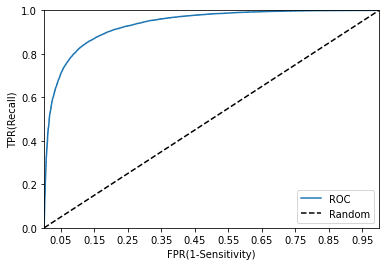

In [28]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# ROC 곡선의 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을반환 받음
    fprs, tprs, thresholds  = roc_curve(y_test, pred_proba_c1)
    # ROC곡선을 그래프로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(test_df['label'],pred_probs[:,1])